In [1]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
import seaborn as sns

In [2]:
spark = SparkSession.builder \
    .appName("Analyse Immatriculations") \
    .config("spark.hadoop.hive.metastore.uris", "thrift://hive-metastore:9083") \
    .enableHiveSupport() \
    .getOrCreate()

In [18]:
spark.sql("USE concessionnaire")
client_immat_df = spark.sql("SELECT * FROM client_immatriculation_merged")

nombre_total_lignes = client_immat_df.count()
print(nombre_total_lignes)
client_immat_df.show(10)

#TODO A CHECK
test = spark.sql("SELECT * FROM client_processed")
test.select("age").distinct().orderBy('age').show(1000)




100000
+---------------+---+-----+----+-------------------+---------------+---------------+----------+---------+-----------+--------+--------+-------+--------+--------+-------------+
|immatriculation|age| sexe|taux|situationfamilliale|nbenfantacharge|deuxiemevoiture|    marque|puissance|   longueur|nbplaces|nbportes|couleur|occasion|    prix|modele_simple|
+---------------+---+-----+----+-------------------+---------------+---------------+----------+---------+-----------+--------+--------+-------+--------+--------+-------------+
|     1017 IM 82| 44|Homme|1042|          En Couple|              3|          false|       BMW|      507|très longue|       5|       5|   bleu|   false| 94800.0|           M5|
|     1030 FY 50| 48|Homme| 156|          En Couple|              1|          false|      Ford|      125|     longue|       5|       5|   noir|    true| 16730.0|       Mondeo|
|     1056 AC 82| 62|Homme| 163|          En Couple|              1|           true|Volkswagen|       55|     cou

In [42]:
null_counts = {column: client_immat_df.filter(F.col(column).isNull()).count() for column in client_immat_df.columns}
print(null_counts)

client_immat_df.describe().show()

client_immat_df.select("modele_simple").distinct().show(100)
client_immat_df.select("longueur").distinct().show()
client_immat_df.select("marque").distinct().show()
client_immat_df.describe(["prix", "puissance"]).show()

{'immatriculation': 0, 'age': 0, 'sexe': 0, 'taux': 0, 'situationfamilliale': 0, 'nbenfantacharge': 0, 'deuxiemevoiture': 0, 'marque': 0, 'puissance': 0, 'longueur': 0, 'nbplaces': 0, 'nbportes': 0, 'couleur': 0, 'occasion': 0, 'prix': 0, 'modele_simple': 0}
+-------+---------------+------------------+-------+-----------------+-------------------+------------------+---------------+------+-----------------+-----------+--------+------------------+-------+------------------+------------------+
|summary|immatriculation|               age|   sexe|             taux|situationfamilliale|   nbenfantacharge|deuxiemevoiture|marque|        puissance|   longueur|nbplaces|          nbportes|couleur|              prix|     modele_simple|
+-------+---------------+------------------+-------+-----------------+-------------------+------------------+---------------+------+-----------------+-----------+--------+------------------+-------+------------------+------------------+
|  count|         100000|     

In [24]:
# Doublon à fix
immatriculation_counts = client_immat_df.groupBy("Immatriculation").agg(F.count("*").alias("nombre_occurences"))
doublons_immatriculation = immatriculation_counts.filter(F.col("nombre_occurences") > 1)

doublons_immatriculation.show(truncate=False)

doublons_list = [row["Immatriculation"] for row in doublons_immatriculation.collect()]
doublons_lignes = client_immat_df.filter(F.col("Immatriculation").isin(doublons_list))

doublons_lignes.show(truncate=False)

+---------------+-----------------+
|Immatriculation|nombre_occurences|
+---------------+-----------------+
|3491 UO 84     |2                |
|9643 KU 76     |2                |
|4129 RI 55     |2                |
|9387 QD 31     |2                |
|7575 RU 54     |2                |
|7139 HQ 38     |2                |
|5064 CC 53     |2                |
|8166 CW 64     |2                |
|1769 OU 76     |2                |
+---------------+-----------------+

+---------------+---+-----+----+-------------------+---------------+---------------+----------+---------+-----------+--------+--------+-------+--------+--------+-------------+
|immatriculation|age|sexe |taux|situationfamilliale|nbenfantacharge|deuxiemevoiture|marque    |puissance|longueur   |nbplaces|nbportes|couleur|occasion|prix    |modele_simple|
+---------------+---+-----+----+-------------------+---------------+---------------+----------+---------+-----------+--------+--------+-------+--------+--------+-------------+
|34

In [17]:
distribution_vehicules = client_immat_df.groupBy("situationfamilliale", "modele_simple").agg(F.count("*").alias("nombre_vehicules"))
distribution_vehicules.orderBy(F.desc("nombre_vehicules")).show()



+-------------------+-------------+----------------+
|situationfamilliale|modele_simple|nombre_vehicules|
+-------------------+-------------+----------------+
|          En Couple|           M5|           12283|
|        Célibataire|           A2|           10251|
|          En Couple|       X-Type|            8168|
|          En Couple|          S80|            5830|
|          En Couple|          Vel|            5676|
|          En Couple|         S500|            4892|
|          En Couple|           A2|            3980|
|          En Couple|          9.3|            3633|
|          En Couple|        Croma|            3261|
|          En Couple|       Mondeo|            3249|
|          En Couple|       Laguna|            3155|
|        Célibataire|         Polo|            3088|
|        Célibataire|         1007|            2899|
|        Célibataire|         Golf|            2609|
|        Célibataire|       Megane|            2584|
|        Célibataire|         A200|           

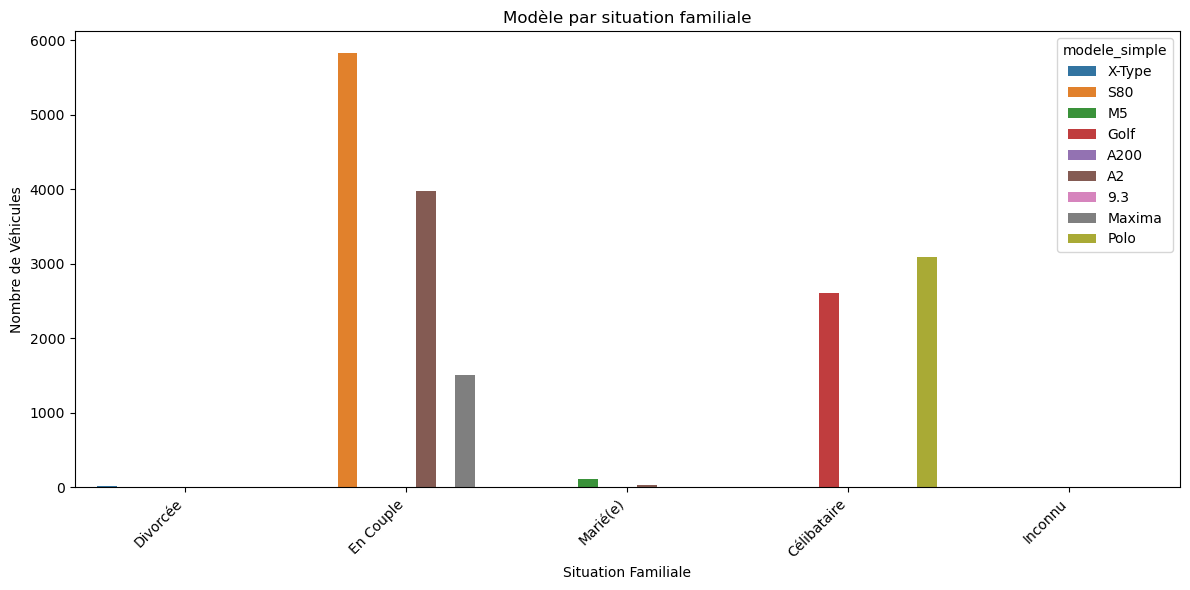

In [30]:
distribution_vehicules_pandas = distribution_vehicules.toPandas()
top_10_distribution = distribution_vehicules_pandas.head(10)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_distribution, x='situationfamilliale', y='nombre_vehicules', hue='modele_simple')

plt.xlabel('Situation Familiale')
plt.ylabel('Nombre de Véhicules')
plt.title('Modèle par situation familiale')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

In [32]:
# Calculer la puissance moyenne par situation familiale
puissance_moyenne_par_situation = client_immat_df.groupBy("situationfamilliale").agg(F.avg("puissance").alias("puissance_moyenne"))
puissance_moyenne_par_situation.show()


+-------------------+------------------+
|situationfamilliale| puissance_moyenne|
+-------------------+------------------+
|        Célibataire|115.09069355575869|
|           Divorcée|237.38709677419354|
|            Inconnu| 205.8357142857143|
|          En Couple|245.61088539550582|
|           Marié(e)| 240.9283536585366|
+-------------------+------------------+



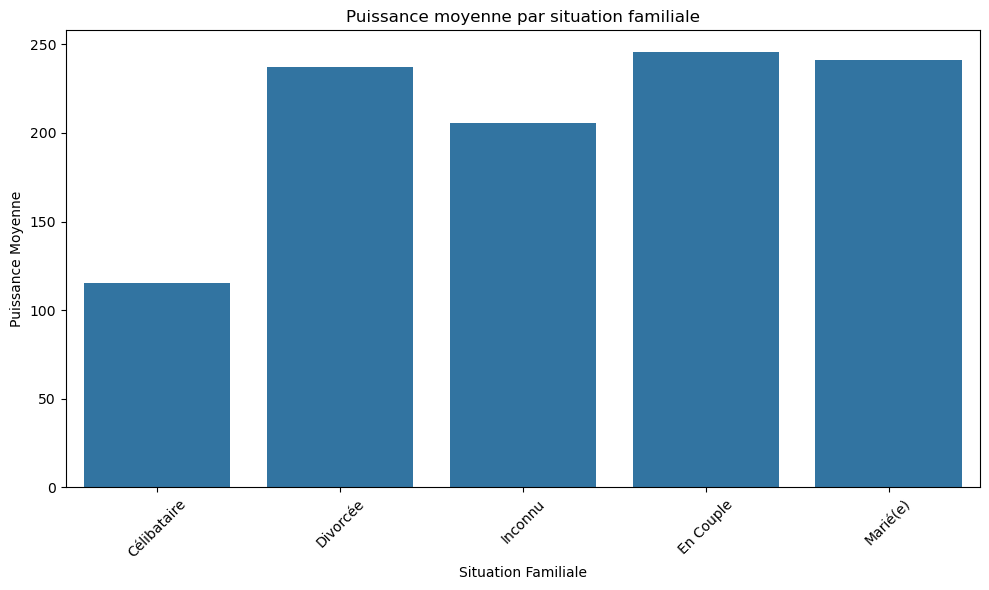

In [38]:
puissance_moyenne_par_situation_pandas = puissance_moyenne_par_situation.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(data=puissance_moyenne_par_situation_pandas, x="situationfamilliale", y="puissance_moyenne")
plt.xlabel('Situation Familiale')
plt.ylabel('Puissance Moyenne')
plt.title('Puissance moyenne par situation familiale')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


+---------------+------------------+
|    tranche_age|        prix_moyen|
+---------------+------------------+
|      30-39 ans| 35202.62427196006|
|      40-59 ans| 35164.03625794079|
| 60 ans et plus| 38418.42594718714|
|Moins de 30 ans|35464.361315462396|
+---------------+------------------+



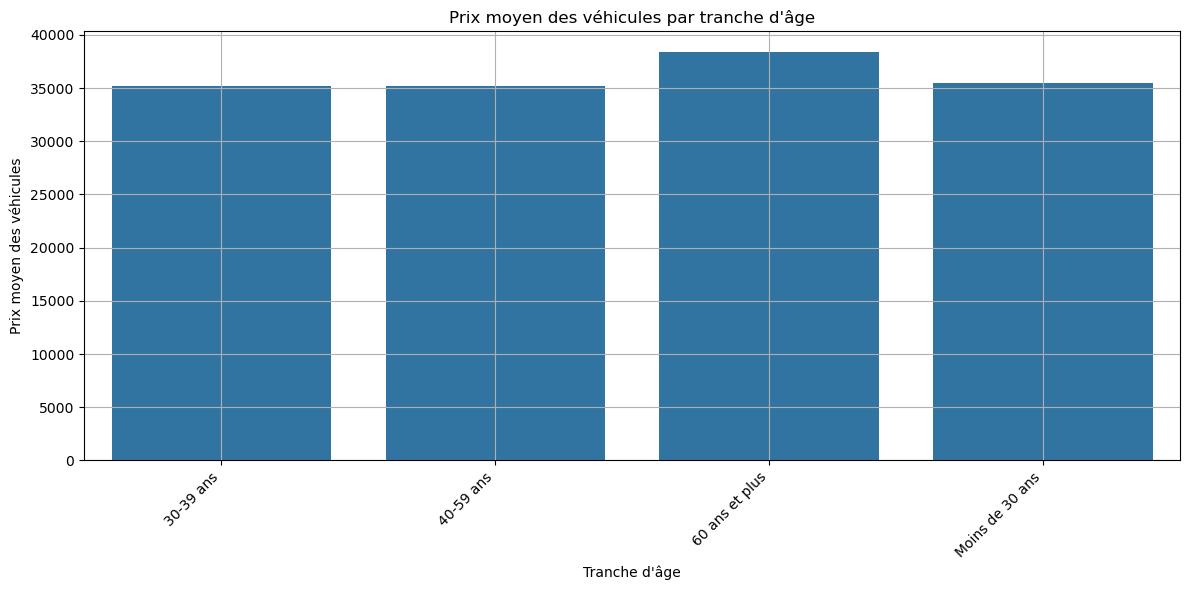

In [15]:
client_immat_df = client_immat_df.withColumn("tranche_age",
                                             F.when(F.col("age") < 30, "Moins de 30 ans")
                                             .when((F.col("age") >= 30) & (F.col("age") < 40), "30-39 ans")
                                             .when((F.col("age") >= 40) & (F.col("age") < 60), "40-59 ans")
                                             .otherwise("60 ans et plus"))

prix_moyen_par_tranche_age = client_immat_df.groupBy("tranche_age").agg(F.avg("prix").alias("prix_moyen"))

prix_moyen_par_tranche_age = prix_moyen_par_tranche_age.orderBy(F.col("tranche_age"))

prix_moyen_par_tranche_age.show()

prix_moyen_par_tranche_age_pandas = prix_moyen_par_tranche_age.toPandas()
plt.figure(figsize=(12, 6))
sns.barplot(data=prix_moyen_par_tranche_age_pandas, x="tranche_age", y="prix_moyen")

plt.xlabel("Tranche d'âge")
plt.ylabel("Prix moyen des véhicules")
plt.title("Prix moyen des véhicules par tranche d'âge")
plt.xticks(rotation=45, ha='right')
plt.grid(visible=True)
plt.tight_layout()

plt.show()

+----+------------------+
|taux|puissance_moyenne |
+----+------------------+
|-1  |202.1264367816092 |
|150 |146.54761904761904|
|151 |141.69543147208122|
|152 |144.14814814814815|
|153 |153.76923076923077|
|154 |140.5923913043478 |
|155 |145.82882882882882|
|156 |144.32820512820513|
|157 |141.04615384615386|
|158 |153.31052631578947|
|159 |146.0             |
|160 |156.7807486631016 |
|161 |137.7462686567164 |
|162 |134.25125628140702|
|163 |149.61951219512196|
|164 |141.03809523809525|
|165 |149.51063829787233|
|166 |147.20320855614975|
|167 |148.44210526315788|
|168 |143.45054945054946|
+----+------------------+
only showing top 20 rows



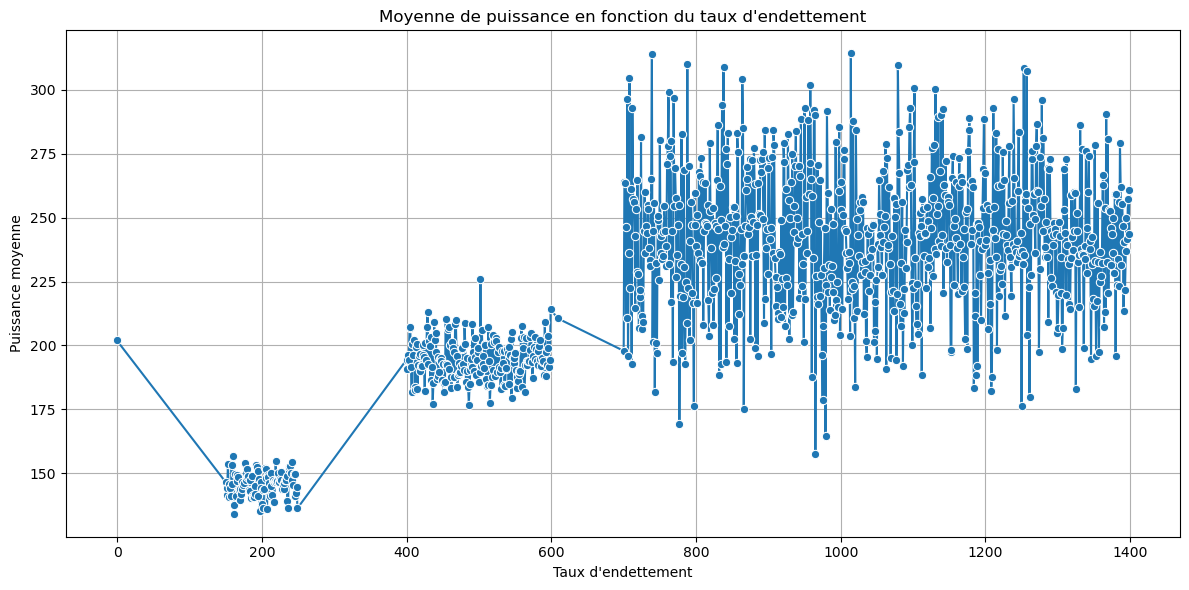

In [16]:
puissance_par_taux = client_immat_df.groupBy("taux").agg(F.avg("puissance").alias("puissance_moyenne"))
puissance_par_taux.orderBy("taux").show(truncate=False)

puissance_par_taux_pandas = puissance_par_taux.toPandas()
plt.figure(figsize=(12, 6))
sns.lineplot(data=puissance_par_taux_pandas, x="taux", y="puissance_moyenne", marker="o")
plt.xlabel("Taux d'endettement")
plt.ylabel("Puissance moyenne")
plt.title("Moyenne de puissance en fonction du taux d'endettement")
plt.grid(visible=True)
plt.tight_layout()

plt.show()

In [19]:
numerical_columns = ["age", "taux", "nbenfantacharge", "puissance", "prix"]
numerical_df = client_immat_df.select(numerical_columns)

numerical_df_pandas = numerical_df.toPandas()

# Calculer la matrice de corrélation
corr_matrix = numerical_df_pandas.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Matrice de Corrélation entre les Caractéristiques des Clients et des Véhicules")
plt.tight_layout()
plt.show()

ValueError: could not convert string to float: ' '